For more accuracy, we need to add some more features which are given:
There are three types of features which we gonna add

Advanced Features

1. Token Features

1. cwc_min: This is the ratio of the number of common words to the length of the smaller question.
2. cwc_max: This is the ratio of the number of common words to the length of the larger question.
3. csc_min: This is the ratio of the number of common stop words to the smaller stop word count among the two questions.
4. csc_max: This is the ratio of the number of common stop words to the larger stop word count among the two questions.
5. ctc_min: This is the ratio of the number of common tokens to the smaller token count among the two questions.
6. ctc_max: This is the ratio of the number of common tokens to the larger token count among the two questions.
7. last_word_eq: 1 if the last word in the two questions is same, 0 otherwise.
8. first_word_eq: 1 if the first word in the two questions is same, 0 otherwise.

2. Length Based Features

1. mean_len: Mean of the length of the two questions(number of words)
2. abs_len_diff: Absolute difference between the length of the two questions(number of words)
3. longest_substr_ratio: Ratio of the length of the longest substring among the two questions to the length of the smaller question.

3. Fuzzy Features

1. fuzz ratio: fuzz_ratio score from fuzzywuzzy
2. fuzz_partial_ratio: fuzz_partial_ratio from fuzzywuzzy
3. token_sort_ratio: token_sort_ratio from fuzzywuzzy
4. token_set_ratio: token_set_ratio from fuzzywuzy

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"C:\Users\lenovo\Downloads\train.csv\train.csv")

In [3]:
new_df = df.sample(30000,random_state=2)

In [4]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,What is the best marketing automation tool for...,What is the best marketing automation tool for...,1
115086,115086,187729,187730,I am poor but I want to invest. What should I do?,I am quite poor and I want to be very rich. Wh...,0
327711,327711,454161,454162,I am from India and live abroad. I met a guy f...,T.I.E.T to Thapar University to Thapar Univers...,0
367788,367788,498109,491396,Why do so many people in the U.S. hate the sou...,My boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,Consequences of Bhopal gas tragedy?,What was the reason behind the Bhopal gas trag...,0


In [15]:
def preprocess(q):
    q = str(q).lower().strip()

    # Replace certain special characters with their string equivalents
    q = q.replace('%',' percent')
    q = q.replace('$',' dollor ')
    q = q.replace('₹',' rupee ')
    q = q.replace('€',' euro ')
    q = q.replace('@',' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equavalents (not perfect, can be done better to account for some cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ','m ')
    q = q.replace(',000 ','k ')
    q = re.sub(r'([0-9]+)000000000',r'\1b',q)
    q = re.sub(r'([0-9]+)000000',r'\1m',q)
    q = re.sub(r'([0-9]+)000',r'\1k',q)

    # Decontracting words
    # https://en.wikipedia.org/wiki/wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not / are not / is not / has not / have not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'd've": "he would have",
    "he'll": "he shall / he will",
    "he'll've": "he shall have / he will have",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how has / how is / how does",
    "I'd": "I had / I would",
    "I'd've": "I would have",
    "I'll": "I shall / I will",
    "I'll've": "I shall have / I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'd've": "it would have",
    "it'll": "it shall / it will",
    "it'll've": "it shall have / it will have",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had / she would",
    "she'd've": "she would have",
    "she'll": "she shall / she will",
    "she'll've": "she shall have / she will have",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as / so is",
    "that'd": "that would / that had",
    "that'd've": "that would have",
    "that's": "that has / that is",
    "there'd": "there had / there would",
    "there'd've": "there would have",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'd've": "they would have",
    "they'll": "they shall / they will",
    "they'll've": "they shall have / they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what'll've": "what shall have / what will have",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "when's": "when has / when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where has / where is",
    "where've": "where have",
    "who'll": "who shall / who will",
    "who'll've": "who shall have / who will have",
    "who's": "who has / who is",
    "who've": "who have",
    "why's": "why has / why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had / you would",
    "you'd've": "you would have",
    "you'll": "you shall / you will",
    "you'll've": "you shall have / you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuation
    pattern = re.compile(r'\W')
    q = re.sub(pattern, ' ',q).strip()

    return q

In [16]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [18]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [19]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


Now it's time to do some feature engineering. First we add our previous 8 features which we have done on the last notebook

In [20]:
# Adding our first and second feature which are len of q1 and q2
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [21]:
# Adding third and forth feature which are number of words in q1 and q2

new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9


In [22]:
# Adding fifth feature which is finding common words

# Function for common words in question1 and question2
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [23]:
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3


In [24]:
# Adding 6th feature which is Total words of q1 and q2

# Function for total words
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [25]:
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13


In [26]:
# 7th and last feature

new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,12,26,0.46
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,8,24,0.33
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,4,38,0.11
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,1,34,0.03
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,3,13,0.23


In the previous notebook where we have added these 8 features, that data was not preprocessed. But here first we preprocessed the data then added these 8 features

Now we will add some advance features which we have seen on the first cell of this notebook

In [31]:
# Advanced Features
from nltk.corpus import stopwords

# This function will provide all the token features(total 8)
def fetch_token_features(row):
    q1 = row['question1']
    q2 = row['question2']

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Questions pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Questions pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Questions pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # first word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [32]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]     = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]     = list(map(lambda x: x[1], token_features))
new_df["csc_min"]     = list(map(lambda x: x[2], token_features))
new_df["csc_max"]     = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]     = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]     = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]     = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"]     = list(map(lambda x: x[7], token_features))

In [33]:
# Now we have 8 new columns in the dataset
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,word_total,word_share,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,26,0.46,0.874989,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,24,0.33,0.666644,0.666644,0.714276,0.714276,0.583328,0.583328,1.0,1.0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,38,0.11,0.000000,0.000000,0.428565,0.428565,0.149999,0.149999,0.0,0.0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,34,0.03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,13,0.23,0.749981,0.749981,0.000000,0.000000,0.599988,0.599988,1.0,0.0


Now it's time to do Length Based Features(total 3)

In [36]:
!pip install distance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16280 sha256=dcef9aabb085b585aa1db3349295dab8ed407217843349eb0f9f6cd6da0b9a22
  Stored in directory: c:\users\lenovo\appdata\local\pip\cache\wheels\24\a8\58\407063d8e5c1d4dd6594c99d12baa0108570b56a92325587dd
Successfully built distance


In [37]:
import distance

def fetch_length_features(row):
    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3

    # Converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    # Average Token length of both questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [38]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [39]:
# we will get three more columns which are length features(total 3)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.874989,0.999980,0.999980,0.923070,0.923070,1.0,1.0,0.0,13.0,0.855263
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.666644,0.714276,0.714276,0.583328,0.583328,1.0,1.0,3.0,13.5,0.224490
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.000000,0.428565,0.428565,0.149999,0.149999,0.0,0.0,6.0,23.0,0.047619
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,17.0,21.5,0.050847
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.749981,0.000000,0.000000,0.599988,0.599988,1.0,0.0,4.0,7.0,0.542857


Now we will add fuzzy features

In [40]:
!pip install fuzzywuzzy

In [43]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzzy_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [ ]:
def query_point_creator(q1,q2):

    input_query = []

    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))

    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))

    input_query.append(test_common_words(q1, q2))
    input_query.append(test_total_words(q1, q2))

In [44]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new features columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [45]:
print(new_df.shape)
new_df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1,75,76,13,13,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0,48,56,13,16,...,0.583328,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0,104,119,28,21,...,0.149999,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0,58,145,14,32,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0,34,49,5,9,...,0.599988,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


Let's perform EDA on the new columns which we have created now

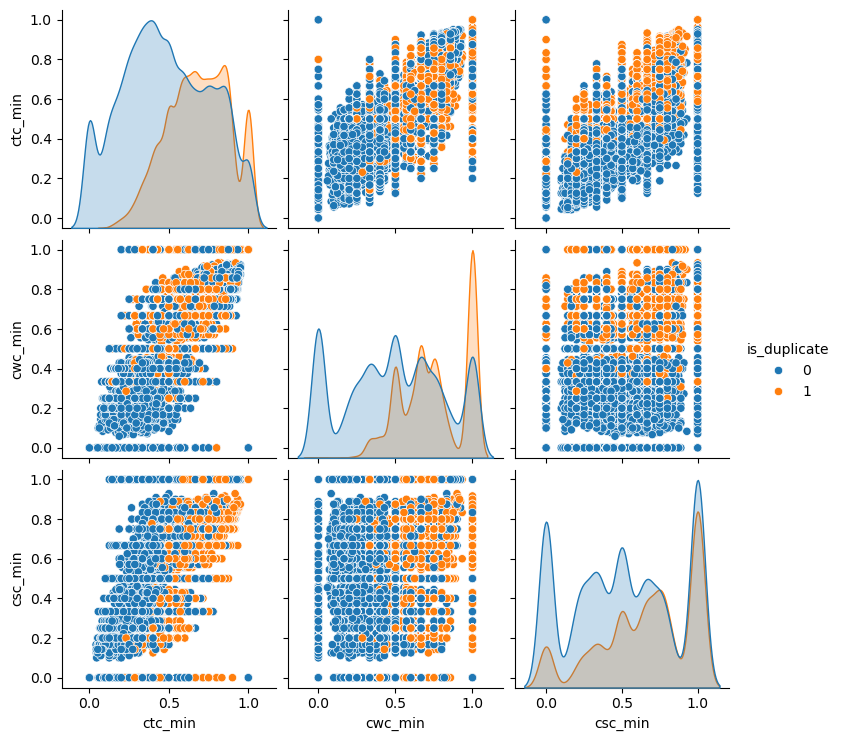

In [46]:
sns.pairplot(new_df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']], hue='is_duplicate')

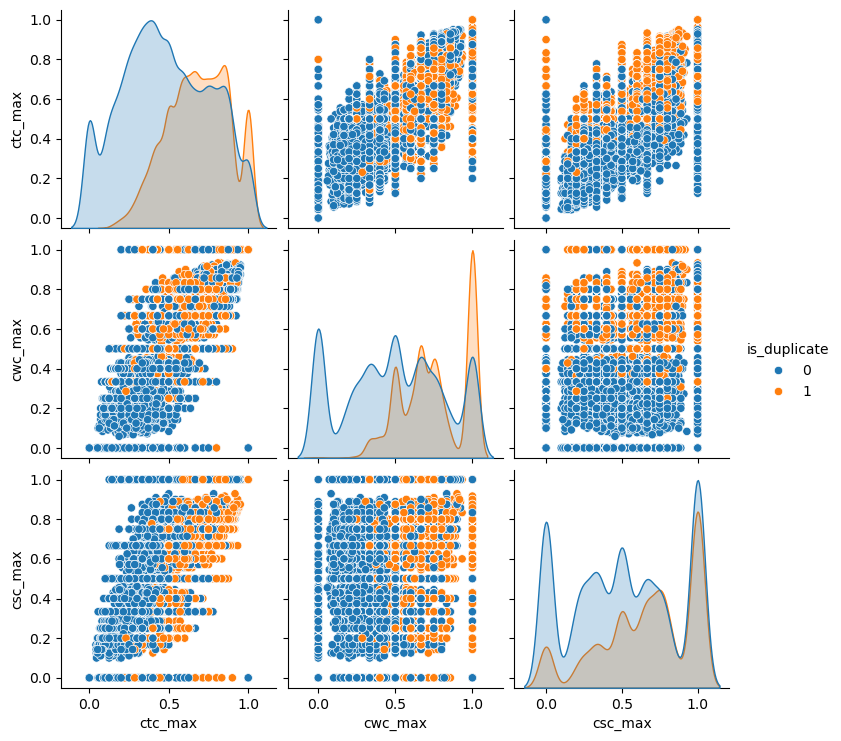

In [47]:
sns.pairplot(new_df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']], hue='is_duplicate')

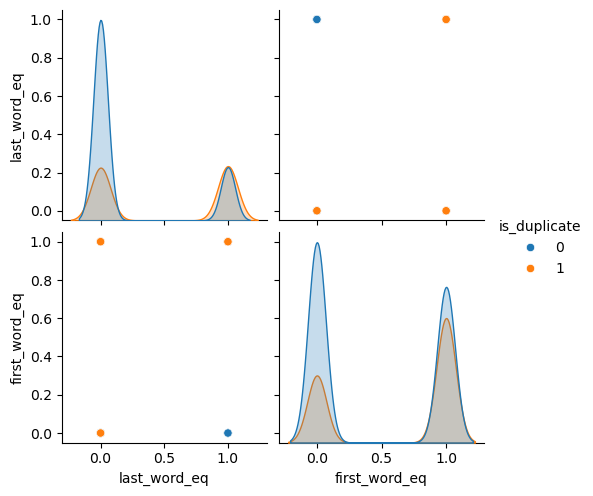

In [48]:
sns.pairplot(new_df[['last_word_eq', 'first_word_eq', 'is_duplicate']], hue='is_duplicate')

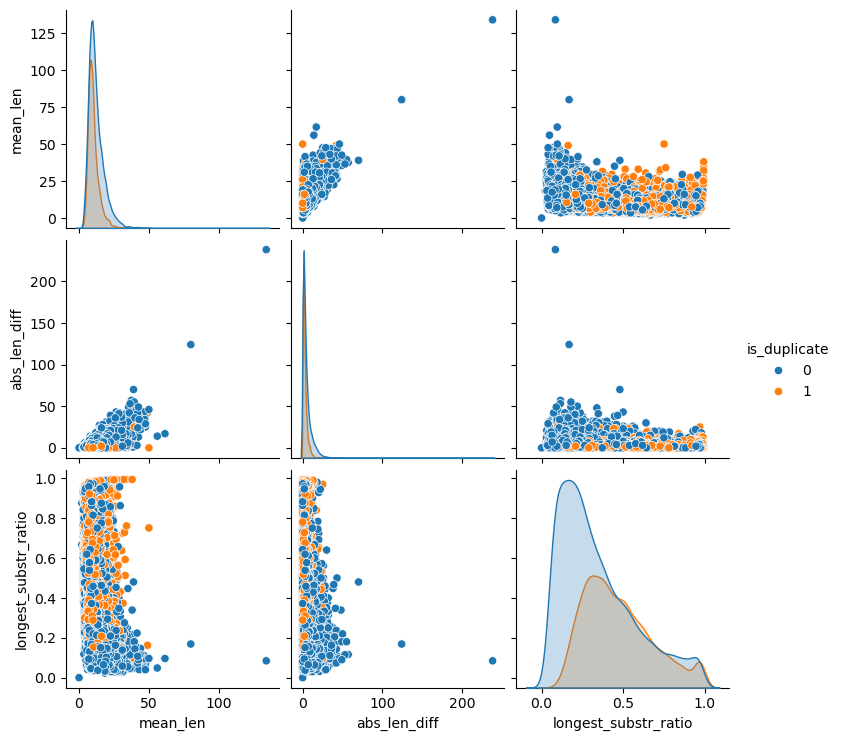

In [50]:
sns.pairplot(new_df[['mean_len', 'abs_len_diff', 'longest_substr_ratio', 'is_duplicate']], hue='is_duplicate')

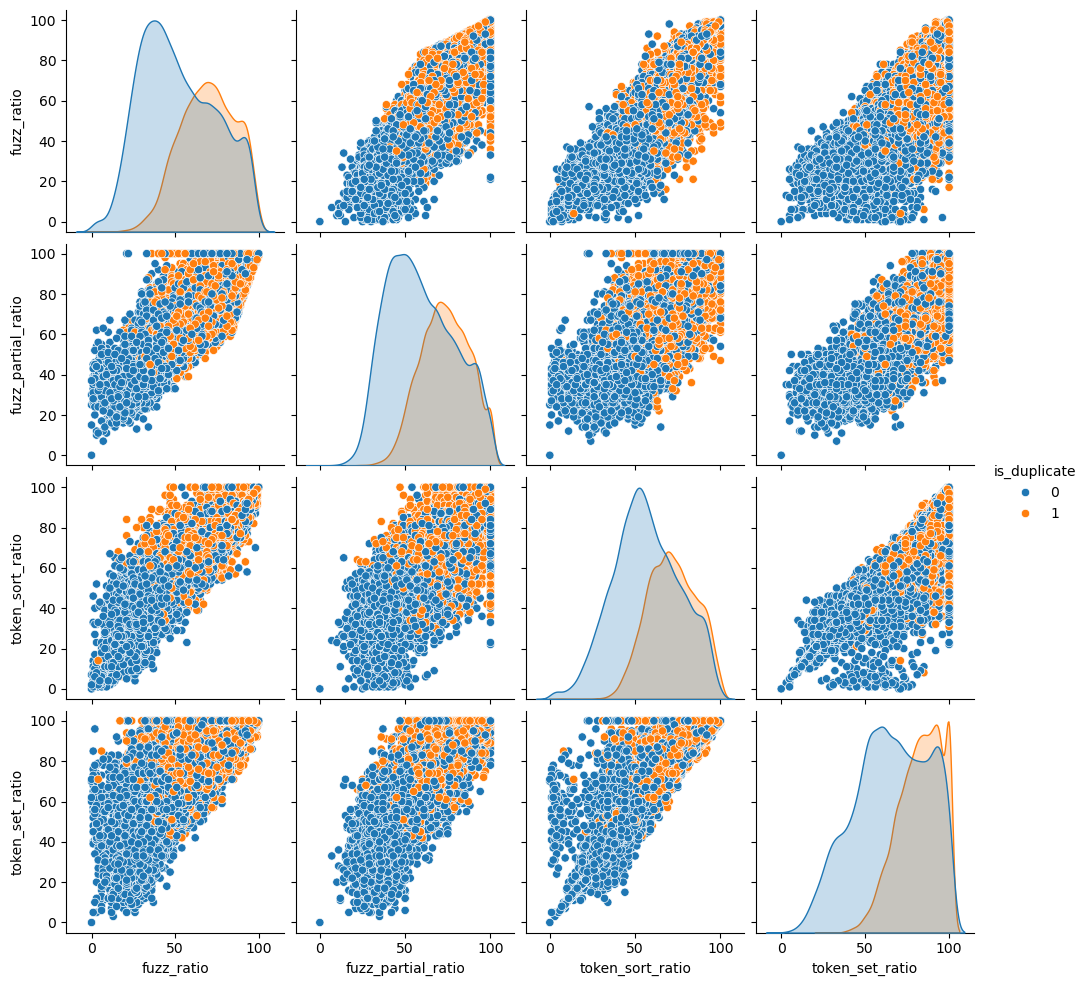

In [51]:
sns.pairplot(new_df[['fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio', 'is_duplicate']], hue='is_duplicate')

In [52]:
# Using TSNE for dimentionality reduction for 15 features(Generate after cleaning the data) to 3 dimesion

from sklearn.preprocessing import MinMaxScaler

x = MinMaxScaler().fit_transform(new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'longest_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio', 'token_sort_ratio', 'token_set_ratio']])
y = new_df['is_duplicate'].values

In [54]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.080s...
[t-SNE] Computed neighbors for 30000 samples in 3.389s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

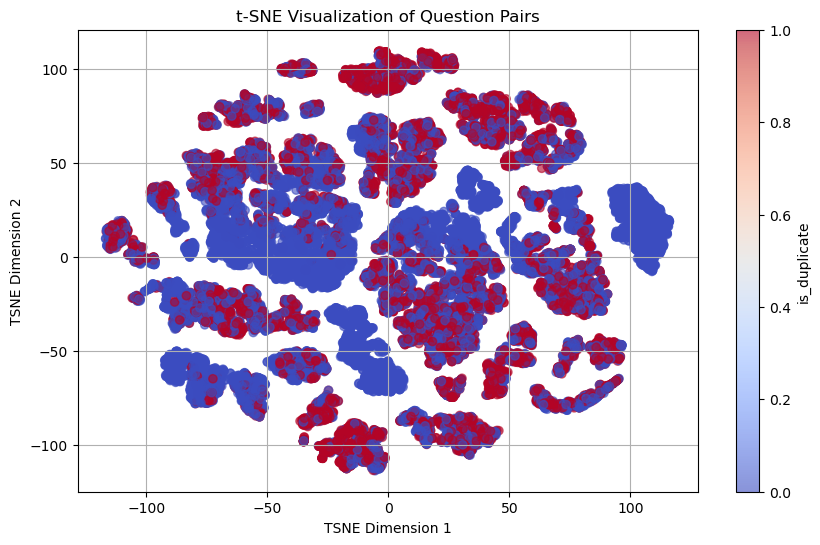

In [55]:
# Create a figure
plt.figure(figsize=(10, 6))

# Scatter plot
# tsne2d[:, 0] is the x-axis, tsne2d[:, 1] is the y-axis
plt.scatter(tsne2d[:, 0], tsne2d[:, 1], c=y, cmap='coolwarm', alpha=0.6)

# Colorbar for class labels
plt.colorbar(label='is_duplicate')

# Labels and title
plt.title("t-SNE Visualization of Question Pairs")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")

# Grid
plt.grid(True)
plt.show()

In [56]:
tsne3d = TSNE(
    n_components=3,
    init='random', #pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.066s...
[t-SNE] Computed neighbors for 30000 samples in 3.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

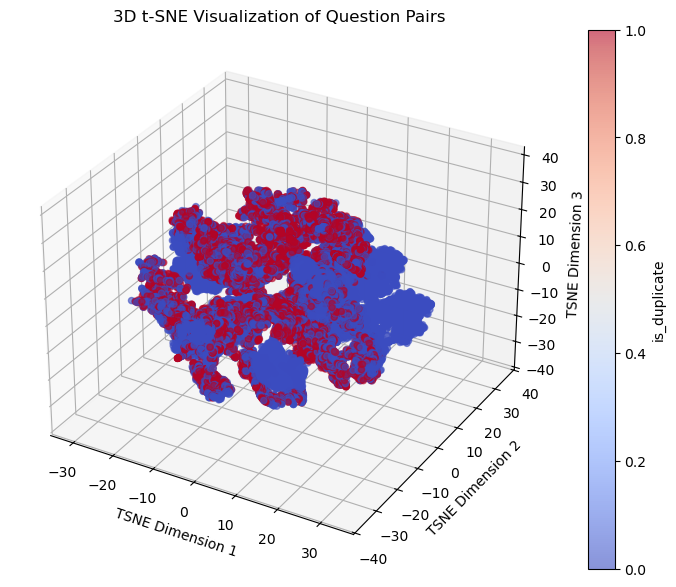

In [58]:
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on 'is_duplicate' labels
scatter = ax.scatter(
    tsne3d[:, 0], tsne3d[:, 1], tsne3d[:, 2],
    c=y, cmap='coolwarm', alpha=0.6
)

# Axis labels
ax.set_title("3D t-SNE Visualization of Question Pairs")
ax.set_xlabel("TSNE Dimension 1")
ax.set_ylabel("TSNE Dimension 2")
ax.set_zlabel("TSNE Dimension 3")

# Colorbar
plt.colorbar(scatter, label='is_duplicate')
plt.show()

In [59]:
# trace1 = go.Scatter3d(
#     x = tsne3d[:, 0],
#     y = tsne3d[:, 1],
#     z = tsne3d[:, 2],
#     mode = 'markers',
#     marker=dict(
#         sizemode='diameter',
#         color=y,
#         colorscale='Portland',
#         colorbar=dict(title='duplicate'),
#         line=dict(color='rgb(255, 255, 255)')
#         opacity=0.75
#     )
# )

# data=[trace1]
# layout=dict(height=800, width=800, title='3d embedding with engineered features')
# fig=dict(data=data, layout=layout)
# py.iplot(fig, filename)

In [60]:
ques_df = new_df[['question1','question2']]
ques_df.head()

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy


In [61]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()
# We have all basic and advanced features in final_df

(30000, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.923070,1.0,1.0,0.0,13.0,0.855263,99,99,99,99
115086,0,48,56,13,16,8,24,0.33,0.666644,0.666644,...,0.583328,1.0,1.0,3.0,13.5,0.224490,69,67,65,74
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.149999,0.0,0.0,6.0,23.0,0.047619,26,29,34,43
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.000000,0.0,0.0,17.0,21.5,0.050847,29,41,23,30
151235,0,34,49,5,9,3,13,0.23,0.749981,0.749981,...,0.599988,1.0,0.0,4.0,7.0,0.542857,55,70,48,69


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [64]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [65]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()
# In this dataset we have total 6023 features

(30000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0,0,0,0,0,0,0,0,0,0
115086,0,48,56,13,16,8,24,0.33,0.666644,0.666644,...,0,0,0,0,0,0,0,0,0,0
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0,0,0,1,0,0,0,0,0,0
151235,0,34,49,5,9,3,13,0.23,0.749981,0.749981,...,0,0,0,0,0,0,0,0,0,0


In this dataset we have total 6023 features where first 3000 features are from bow of q1 and other 3000 features are from bow of q2.

Remaining 23 = (8 from previous notebook) + (15 advanced features)

In [66]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=2)

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

0.787

Now we can see that accuracy has improve to 78.7% by using RandomForestClassifier

In [71]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred1 = xgb.predict(x_test)
accuracy_score(y_test, y_pred1)

0.782

by using XGBClassifier accuracy is 78.2%

In [72]:
from sklearn.metrics import confusion_matrix

In [73]:
# for random forest model
confusion_matrix(y_test, y_pred)

array([[3168,  622],
       [ 686, 1524]], dtype=int64)

In [74]:
# for XGBoost model
confusion_matrix(y_test, y_pred1)

array([[3168,  622],
       [ 686, 1524]], dtype=int64)